In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pywt.data
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os 
from PIL import Image
Image.MAX_IMAGE_PIXELS = 900_000_000
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris, load_wine
from sklearn.cluster import DBSCAN
import seaborn as sns
from collections import Counter

In [2]:
sa_pop = mpimg.imread('../zaf_ppp_2019.tif')

In [3]:
sa_pop_csv = pd.read_csv(filepath_or_buffer = './data/population_zaf_2018-10-01.csv')

In [4]:
sa_pop_csv.describe().T

,count,mean,std,min,25%,50%,75%,max
Lat,10605372.0,-28.256131,3.148587,-34.830694,-30.765139,-27.889861,-25.767083,-22.131250
Lon,10605372.0,28.063472,3.095862,16.475417,27.278750,28.547917,30.195417,32.877917
Population,10605372.0,5.131888,7.642488,0.007200,2.140180,3.353750,5.458840,2192.072110


In [5]:
jberg_pop = sa_pop_csv.loc[ (sa_pop_csv['Lat'].between(left = -26.2,
                                                       right = -26.1)) &\
                            (sa_pop_csv['Lon'].between(left = 27.9,
                                                         right = 28.1))]

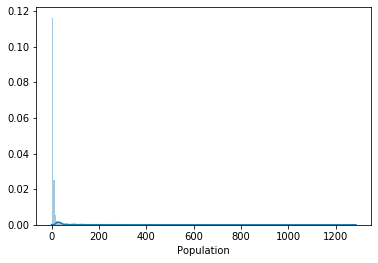

In [15]:
sns.distplot(a = jberg_pop['Population'],
             bins = 200)

In [86]:
jberg_pop_truncated = jberg_pop.loc[jberg_pop['Population'] >= 1.1 * jberg_pop['Population'].min()]

In [87]:
jberg_pop_truncated.describe().T

,count,mean,std,min,25%,50%,75%,max
Lat,100211.0,-26.148334,0.028476,-26.199861,-26.173472,-26.147639,-26.123472,-26.100139
Lon,100211.0,28.002397,0.057652,27.900139,27.953750,28.001528,28.052361,28.099861
Population,100211.0,8.502738,22.740921,0.078190,3.492670,4.618400,6.554530,1286.048750


In [88]:
jberg_pop_scaler = StandardScaler()
jberg_pop_scaler.fit(X = jberg_pop_truncated)
jberg_pop_scaled = pd.DataFrame(data = jberg_pop_scaler.transform(X = jberg_pop_truncated),
                                columns = jberg_pop_truncated.columns,
                                index = jberg_pop_truncated.index)
jberg_pop_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
Lat,100211.0,-5.225927e-14,1.000005,-1.809463,-0.882764,0.024424,0.873086,1.692481
Lon,100211.0,-5.281144e-14,1.000005,-1.773702,-0.843795,-0.015069,0.866656,1.690563
Population,100211.0,-3.892640e-15,1.000005,-0.370459,-0.220312,-0.170809,-0.085670,56.178568


In [89]:
jberg_pop_dbscan = DBSCAN(eps = 0.4,
                          min_samples = 5)
jberg_pop_dbscan.fit(jberg_pop_scaled)

DBSCAN(algorithm='auto', eps=0.4, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [90]:
twilight_shifted = dict(zip(jberg_pop_dbscan.labels_,
                             cm.get_cmap('twilight_shifted', len(jberg_pop_dbscan.labels_)).colors))
twilight_shifted.update({idx : np.concatenate((twilight_shifted.get(idx)[:-1], np.array([0])))
                         for idx in {-1, 0}})

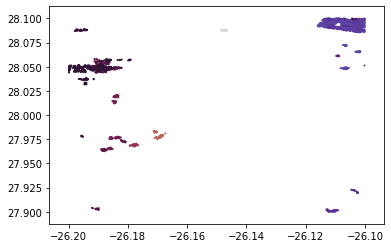

In [92]:
plt.scatter(jberg_pop_truncated['Lat'],
            jberg_pop_truncated['Lon'],
            color = pd.Series(data = jberg_pop_dbscan.labels_).map(twilight_shifted),
            s = 1)

In [67]:
np.put(a = twilight_shifted.get(0),
       ind = 3,
       v = 0)

In [68]:
twilight_shifted.get(0)

array([0.18488036, 0.07942573, 0.21307652, 0.        ])